# Exhibits from report *Beyond Actual to Table*

This notebook duplicates most of the exhibits in [Beyond Actual to Table](https://www.soa.org/resources/research-reports/2018/beyond-actual-table/).  Results differ slightly from the published report, due largely to slight differences between the published dataset used here and the earlier dataset available only to the ILEC.  I included most of the exhibits besides the tree model.

Orignial SOA report appendix G:
* Site: https://www.soa.org/resources/experience-studies/2017/2009-13-indiv-life-ins-mort-exp/
* Appendices: https://www.soa.org/globalassets/assets/files/research/exp-study/2009-13-indiv-life-ins-mort-exp-appendix.xlsx

Run the notebook to initialize the libraries and generate exhibits from the report.


# Initialize libraries

In [1]:
# set these paramaters for your environment before running.
DIR_HOME = str(Path.home())
DIR_DATA = DIR_HOME + '/data/ilec/Data/Processed/2021_published' # set to your directory
DIR_ILECTools = DIR_HOME + '/dev/ILECTools' # if you have not installd the directory you'll need this.

In [1]:
import os
import sys
import re
import pandas as pd
import numpy as np
from pathlib import Path

from IPython.display  import display, HTML, Markdown

# In case you haven't installed ILECTools, this bit will get the ilectools directory into 
# your search path to its functions can be imported.

if not any([Path(_p).name=='ILECTools' for _p in sys.path]):
    sys.path.append(DIR_ILECTools) # is where it is on this machine

from ilectools import a2t

%config Completer.use_jedi=False # helps with autocompleter in notebook in some configurations
pd.options.display.float_format = '{:,.0f}'.format
pd.options.display.width=255
pd.options.display.max_rows = 100

# Initialize data

The data must be preprocessed in advance.
* Take subset for exhibit G.
* Summarize data on variables used in models so Poisson regression will not choke.

In [2]:
%%time
data = a2t.append_columns_for_model(
    pd.read_parquet(DIR_DATA + '/ILEC 2009-18 20210528_v2.parquet')
    )

# subset of data for exhibit g, the example used in 
data_exhibit_g = a2t.exhibit_g_subset(data)

del data # why not free up a few gb of RAM
# tidiness
import gc
gc.collect()

CPU times: user 33 s, sys: 11.2 s, total: 44.1 s
Wall time: 42 s


19

In [3]:
# model will run better on a summary - or: will run at all
# Fields aggregated here, value columns    
data_exhibit_g_summary = data_exhibit_g.pivot_table(
    index='uw,face_amount_band,observation_year,dur_band1,ia_band1,gender,insurance_plan,ltp,iy_band1'.split(','), 
    values=['policy_actual', 'policy_2015vbt', 'amount_actual', 'amount_2015vbt'], 
    aggfunc=np.sum).reset_index()

# Run models

In [4]:
%%time
# get policy and amount models
models = {
    m:a2t.PoissonWrapper(
        offset_column=f'{m}_2015vbt'
      , formula = f"""{m}_actual ~
                + C(uw, Treatment(reference='N/2/1'))
                + C(dur_band1, Treatment(reference='06-10'))
                + C(face_amount_band, Treatment(reference='  100000-249999'))
                + C(ia_band1, Treatment(reference='40-44'))
                + C(gender)
                + C(observation_year)
                + C(insurance_plan, Treatment(reference='Term'))
                + C(ltp, Treatment(reference='20 yr or N/A (Not Term)'))
                + C(iy_band1)
            """
      , data = data_exhibit_g_summary
    )
    for m
    in ['policy', 'amount']
}

Optimization terminated successfully.
         Current function value: 0.395291
         Iterations 6
Optimization terminated successfully.
         Current function value: 93580.917352
         Iterations 6
CPU times: user 1min 19s, sys: 39.8 s, total: 1min 59s
Wall time: 26.4 s


Append model results to the dataframe.

In [5]:
for model_item in ['policy', 'amount']:
    data_exhibit_g_summary[f'{model_item}_{model_item}model'] = models[model_item].fit.predict()
# adjust each 2015vbt tabular amount (policy or amount) by the model factor from modelling the other one:
data_exhibit_g_summary['policy_amountmodel'] = (data_exhibit_g_summary['amount_amountmodel'] / data_exhibit_g_summary['amount_2015vbt']
                                                * data_exhibit_g_summary['policy_2015vbt'])
data_exhibit_g_summary['amount_policymodel'] = (data_exhibit_g_summary['policy_policymodel'] / data_exhibit_g_summary['policy_2015vbt']
                                                * data_exhibit_g_summary['amount_2015vbt'])

Using factors for the amount model will duplicate the total amount, using factors for the policy model will return a bit different amount in total, and vice versa for the policy count model:

In [6]:
data_exhibit_g_summary.filter(regex='(model|actual)$').sum().sort_index()

amount_actual        82,334,814,776
amount_amountmodel   82,334,814,776
amount_policymodel   82,947,445,771
policy_actual               623,265
policy_amountmodel          617,185
policy_policymodel          623,265
dtype: float64

# Appendix 1

In [7]:
for t0, basis in zip([2, 3, 4],
                     ['2015vbt', 'policymodel', 'amountmodel']):
    for t1, metric in zip(['a', 'b'], 
                          ['policy', 'amount']):
        caption = f"Table {t0}{t1}: Exhibit G actual / {basis} by {metric}; by Plan and Duration"
        display(Markdown('## '+caption)) # show here instead of html table caption to use the TOC feature of notebooks
        display(a2t.get_exhibit_g(data_exhibit_g_summary, metric, basis))

## Table 2a: Exhibit G actual / 2015vbt by policy; by Plan and Duration

## Table 2b: Exhibit G actual / 2015vbt by amount; by Plan and Duration

## Table 3a: Exhibit G actual / policymodel by policy; by Plan and Duration

## Table 3b: Exhibit G actual / policymodel by amount; by Plan and Duration

## Table 4a: Exhibit G actual / amountmodel by policy; by Plan and Duration

## Table 4b: Exhibit G actual / amountmodel by amount; by Plan and Duration

# Appendix 2

In [8]:
import itertools
from IPython.display import Markdown
combos = list(itertools.product(
    ['policy', 'amount'], 
    ['iy_band1', 'uw', 'insurance_plan', 'ltp', 'ia_band1', 'dur_band1', 'observation_year', 'gender', 'face_amount_band']
        ))
plots = {k:m.plot_comparison() for k, m in models.items()} # the plot_comparison precomputes the plots

## Figure 4: Model by policy, factors by iy_band1 vs Actual / 2015VBT

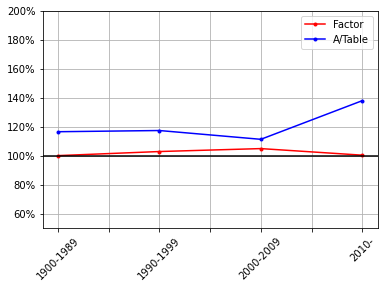

## Figure 5: Model by policy, factors by uw vs Actual / 2015VBT

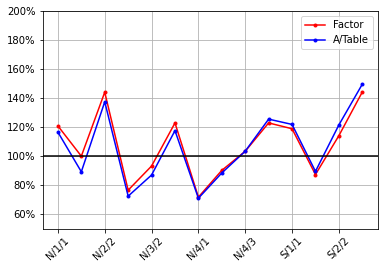

## Figure 6: Model by policy, factors by insurance_plan vs Actual / 2015VBT

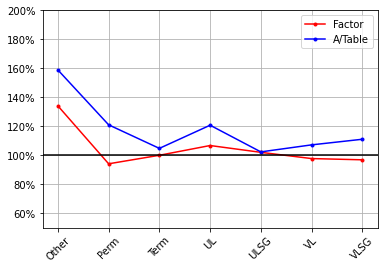

## Figure 7: Model by policy, factors by ltp vs Actual / 2015VBT

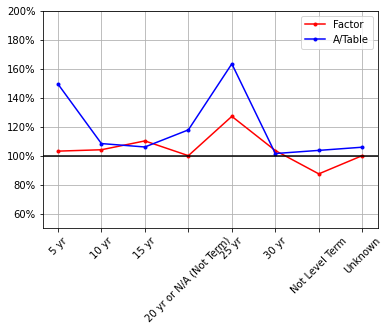

## Figure 8: Model by policy, factors by ia_band1 vs Actual / 2015VBT

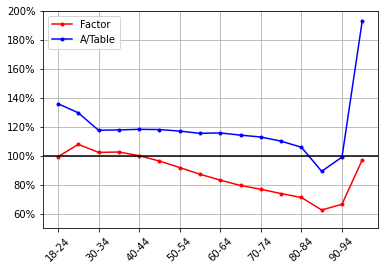

## Figure 9: Model by policy, factors by dur_band1 vs Actual / 2015VBT

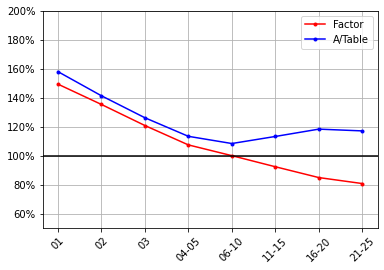

## Figure 10: Model by policy, factors by observation_year vs Actual / 2015VBT

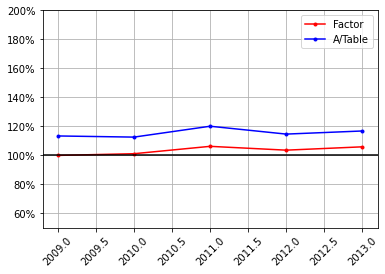

## Figure 11: Model by policy, factors by gender vs Actual / 2015VBT

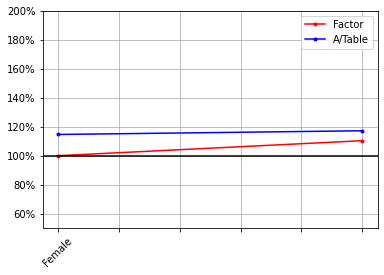

## Figure 12: Model by policy, factors by face_amount_band vs Actual / 2015VBT

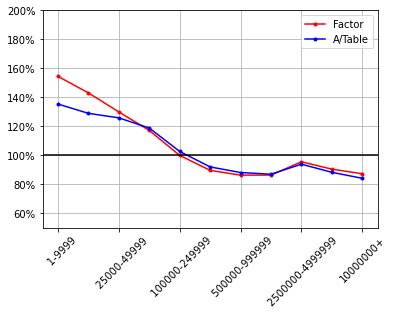

## Figure 13: Model by amount, factors by iy_band1 vs Actual / 2015VBT

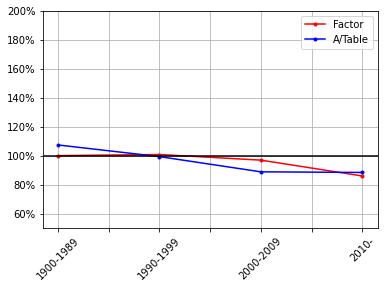

## Figure 14: Model by amount, factors by uw vs Actual / 2015VBT

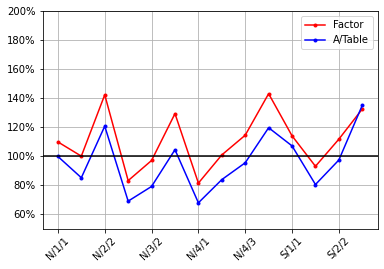

## Figure 15: Model by amount, factors by insurance_plan vs Actual / 2015VBT

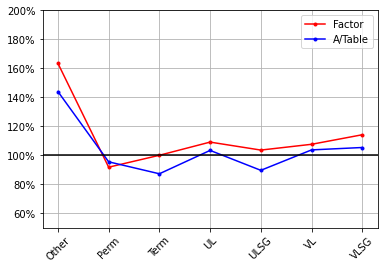

## Figure 16: Model by amount, factors by ltp vs Actual / 2015VBT

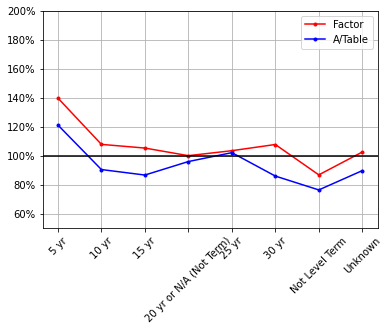

## Figure 17: Model by amount, factors by ia_band1 vs Actual / 2015VBT

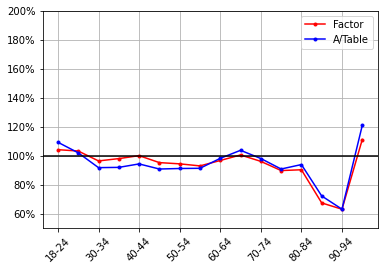

## Figure 18: Model by amount, factors by dur_band1 vs Actual / 2015VBT

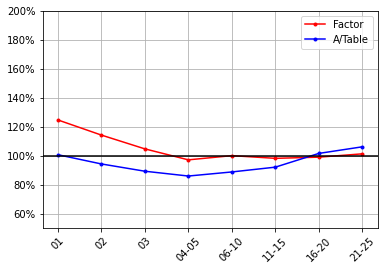

## Figure 19: Model by amount, factors by observation_year vs Actual / 2015VBT

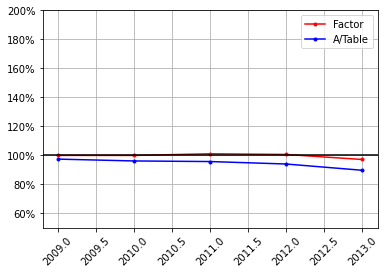

## Figure 20: Model by amount, factors by gender vs Actual / 2015VBT

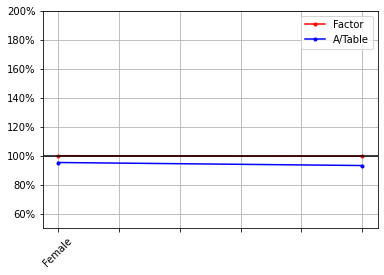

## Figure 21: Model by amount, factors by face_amount_band vs Actual / 2015VBT

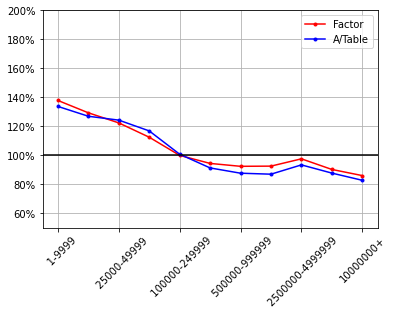

In [9]:
for i, (metric, split) in enumerate(combos):
    # caption
    display(Markdown(f'## Figure {i+4}: Model by {metric}, factors by {split} vs Actual / 2015VBT'))
    m = models[metric]
    
    # graph
    display(plots[metric][split])
    
    # table of numbers
    display(m.factor_analysis_exhibit(split))
    
    display(HTML('<p/>')) # for some space

# End